#  2. Extracting muscle synergies

How can we determine muscle synergies using non-negative matrix factorization in Python?
The goal of this notebook is to figure that out as I read on the topic. We have a sample electromyogram to work with and code to load it to memory. 

## 2.1 Imports and loading the data

We begin by setting up everything: we import the needed libraries and load the data.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import functools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy.signal as signal

from muscle_synergies import load_vicon_file
from muscle_synergies.analysis import (
    butterworth_filter,
    find_synergies,
    plot_emg_signal,
    plot_spectrum,
    positive_spectrum,
    rms_envelope,
    synergy_heatmap,)

In [4]:
cwd = Path().resolve()
data_dir = cwd / '..' / 'sample_data'
abridged_dataset = data_dir / 'abridged_data.csv' # useful for testing
full_dataset = data_dir / 'dynamic_trial.csv'
dataset = full_dataset.resolve()
dataset

PosixPath('/home/elvis/Organização/Projetos/Biomecânica/emg-code/muscle_synergies/sample_data/dynamic_trial.csv')

In [5]:
vicon_data = load_vicon_file(dataset)
emg_dev = vicon_data.emg
emg_df = emg_dev.df
time_seq = emg_dev.time_seq()
emg_df.index = time_seq
del vicon_data
emg_df.shape

(124460, 8)

## 2.2 Plotting the signal

### 2.2.1 Time-domain: plotting the raw EMG signal


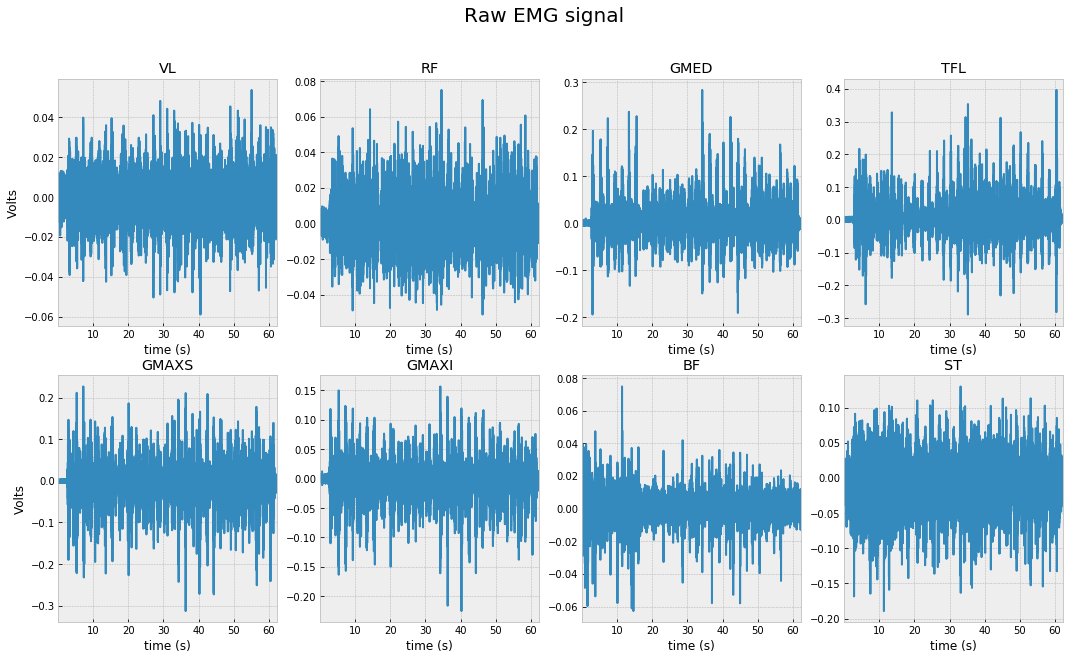

In [6]:
plot_emg_signal(emg_df, 'Raw EMG signal')

### 2.2.2 Frequency-domain: plotting the FFT

We are interested in seeing the frequency-domain version of the EMG signal mostly to look for abnormalities.

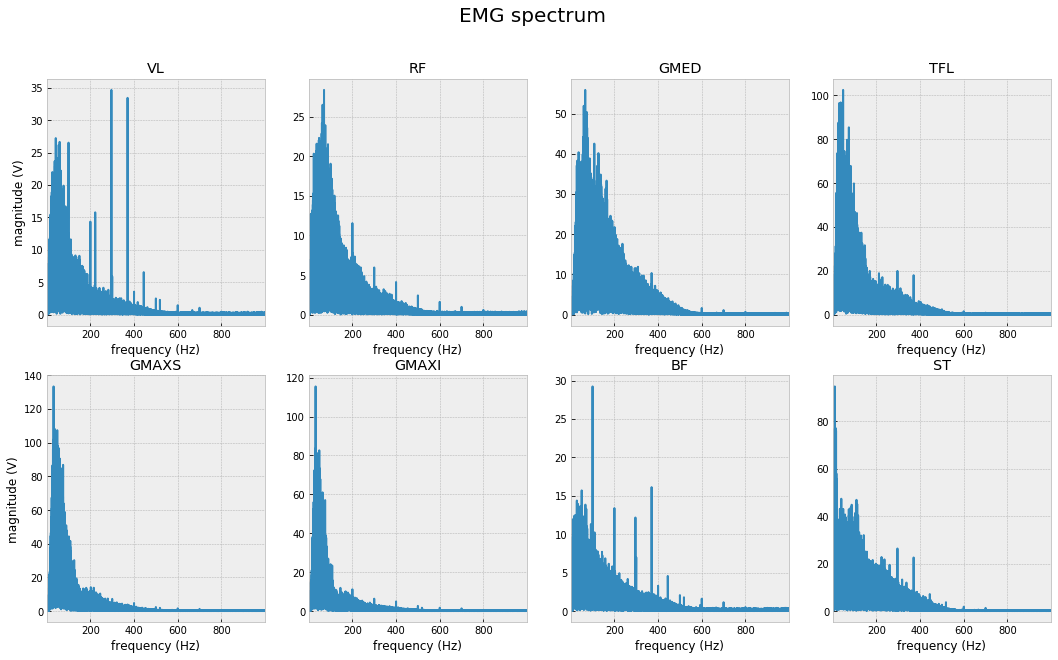

In [7]:
plot_spectrum(emg_df, emg_dev.sampling_frequency)
plt.show()

## 2.3 Zero-centering the signal

We begin processing the data by subtracting the mean of the signal from each of its channels:

In [8]:
emg_df -= emg_df.mean()

## 2.4 Finding the envelope of the signal

We'll investigate both the linear envelope and RMS.

### 2.4.1 Linear envelope

To find the linear envelope, rectify then low-pass filter the signal.

#### 2.4.1.1 Rectifying the signal

Rectify each of the channels of the electromyogram:

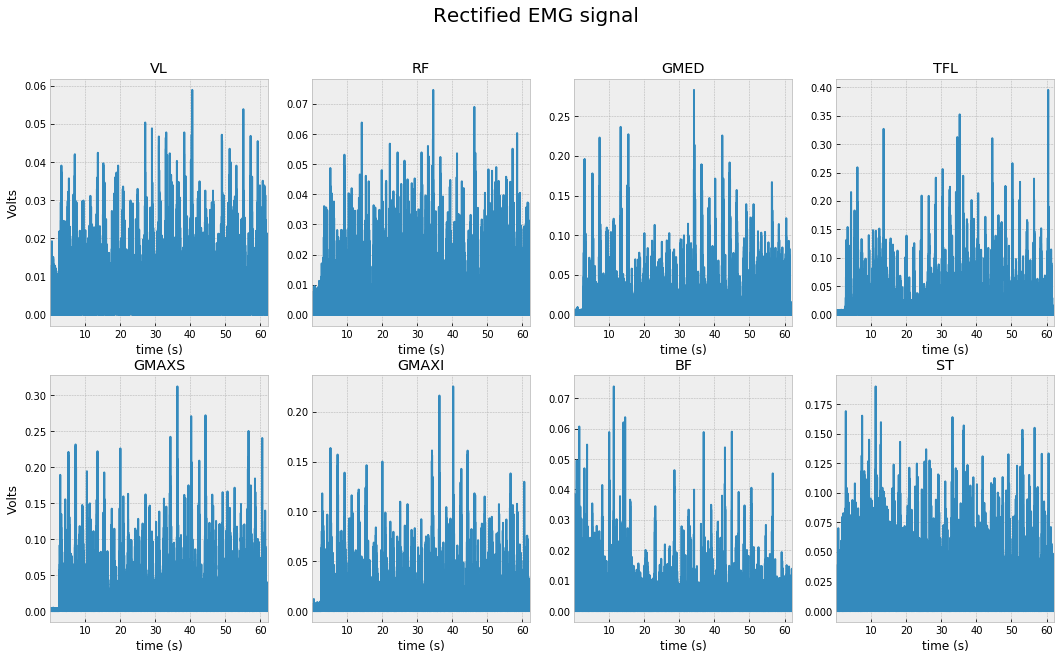

In [9]:
rectified_df = np.abs(emg_df)
plot_emg_signal(rectified_df, 'Rectified EMG signal')

We can be confident that there are no negative values in the signals above since they have been through `np.abs`.

#### 2.4.1.2 Applying the Butterworth filter

Low-pass filter the signal using a zero-lag order Butterworth filter: 

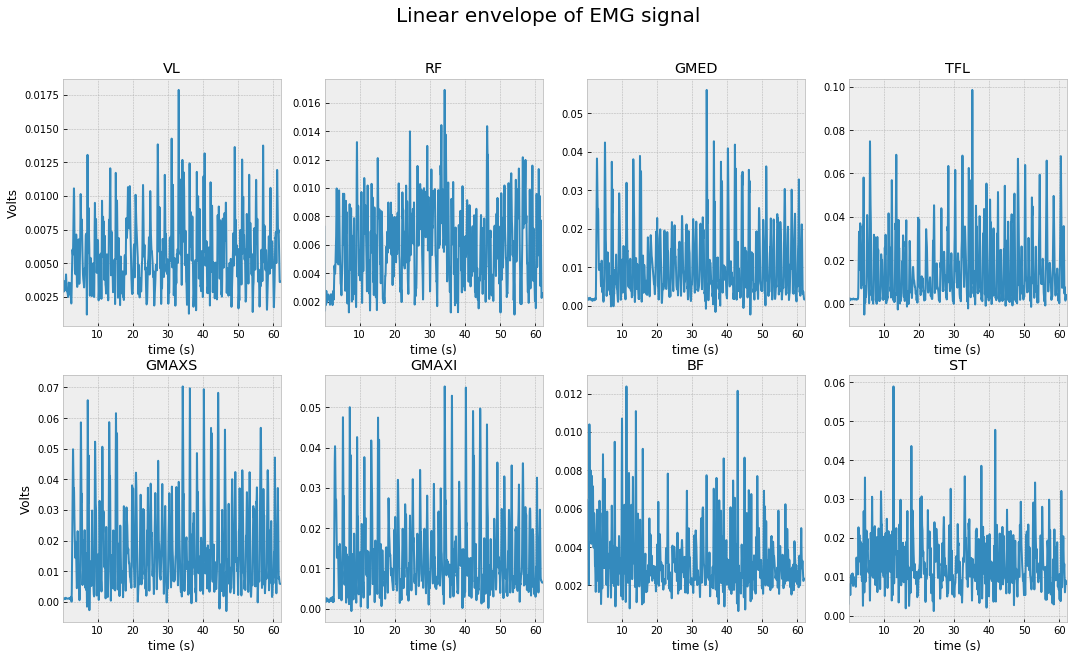

In [15]:
filtered_arr = butterworth_filter(rectified_df.to_numpy(), 4,
                                  emg_dev.sampling_frequency,
                                  order=13, filter_type='lowpass', zero_lag=True)
linear_envelope_df = pandas.DataFrame(filtered_arr, columns=emg_df.columns, 
                                      index=emg_df.index)
plot_emg_signal(linear_envelope_df, 'Linear envelope of EMG signal')

The graphs reveal that some of the channels of the filtered signal become negative at some times. We can check that by looking at the data directly:

In [17]:
(linear_envelope_df < 0).sum()

VL          0
RF          0
GMED      652
TFL      1463
GMAXS     787
GMAXI      71
BF          0
ST          0
dtype: int64

We can see that several of the columns include negative measurements following the application of the low-pass Butterworth filter.

### 2.4.2 RMS

Find the RMS envelope using that transformation:

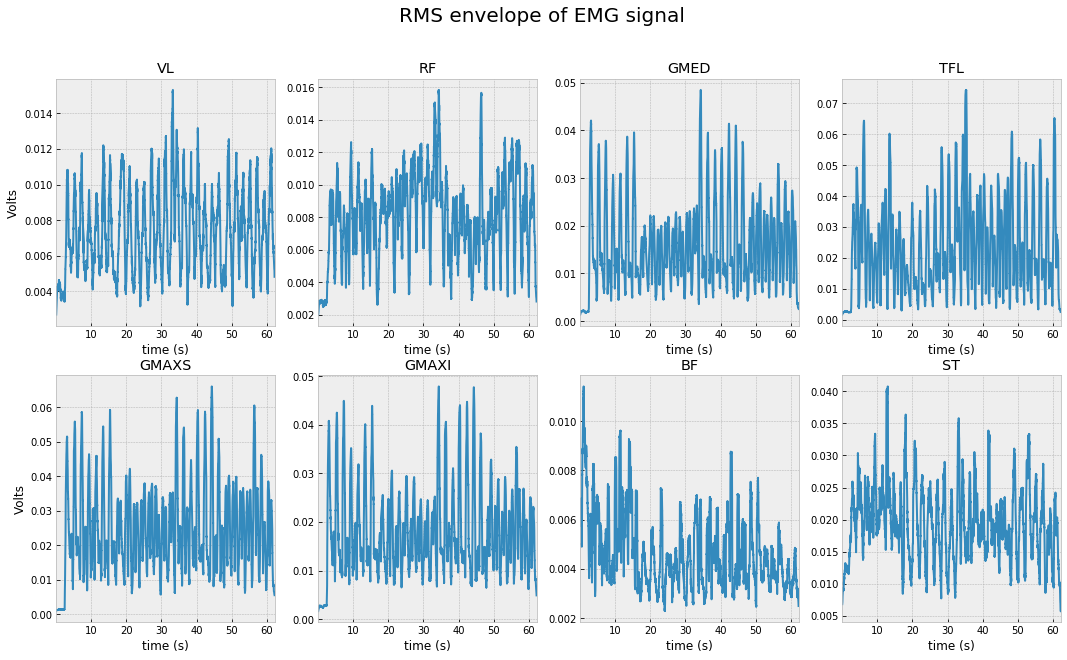

In [12]:
window_size = 1000
filtered_arr = rms_envelope(emg_df, window_size)
rms_envelope_df = pandas.DataFrame(filtered_arr, columns=emg_df.columns, index=emg_df.index)
plot_emg_signal(rms_envelope_df, 'RMS envelope of EMG signal')

We can be sure that the RMS-processed signal will only contain nonnegative values since it squared every value in the raw signal. 
For that reason we opt to use it for further processing:

In [13]:
processed_df = rms_envelope_df

## 2.5 Normalizing the signal

We now normalize the envelope signal in two ways: 

### 2.5.1 Amplitude normalization

The signal is amplitude normalized by dividing all measurements for each of its channels by the maximum value for that channel.

In [14]:
processed_df /= processed_df.max()

### 2.6.2 Time normalization

The signal is sampled down. Its original shape...

In [15]:
processed_df.shape

(124460, 8)

...is reduced by resampling points:

In [16]:
processed_arr = signal.resample(processed_df, 100, axis=0)
processed_df = pandas.DataFrame(processed_arr, columns=emg_df.columns)
processed_df.shape

(100, 8)

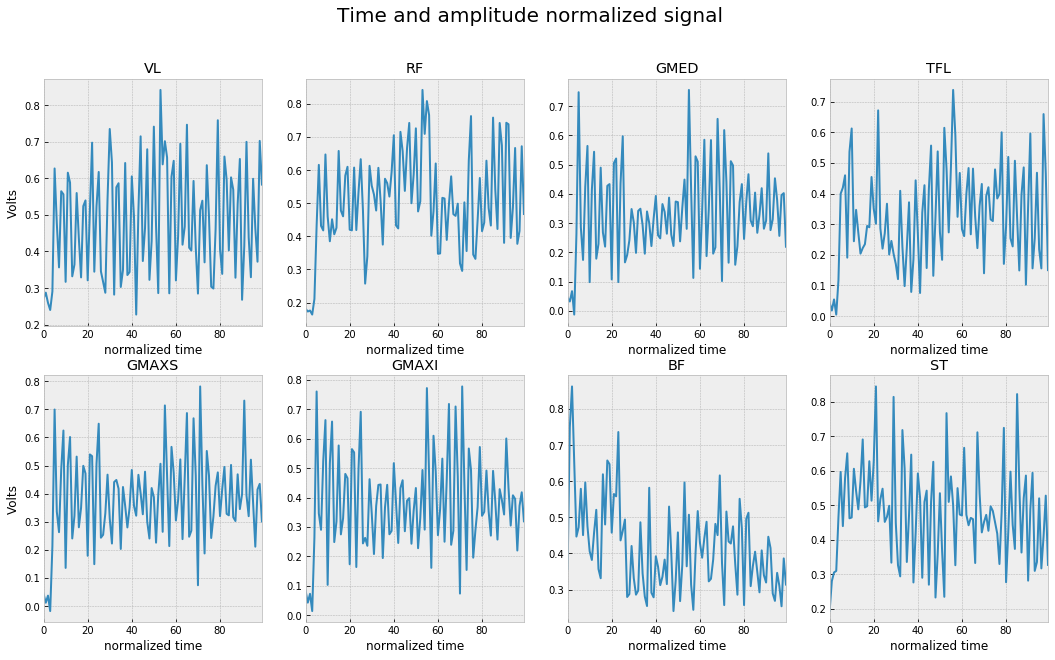

In [17]:
plot_emg_signal(processed_df, 'Time and amplitude normalized signal', xlabel='normalized time')

We make sure that we have no negative measurements:

In [18]:
processed_df[processed_df < 0] = 0
(processed_df < 0).sum()

VL       0
RF       0
GMED     0
TFL      0
GMAXS    0
GMAXI    0
BF       0
ST       0
dtype: int64

In [19]:
processed_df

,VL,RF,GMED,TFL,GMAXS,GMAXI,BF,ST
0,0.271524,0.181203,0.044674,0.044170,0.043201,0.083689,0.356697,0.193597
1,0.287498,0.172903,0.031668,0.018085,0.011959,0.043258,0.749900,0.280511
2,0.259697,0.175896,0.067077,0.054444,0.037253,0.073222,0.861969,0.305547
3,0.240069,0.163679,0.000000,0.005006,0.000000,0.014654,0.652073,0.309877
4,0.290757,0.210779,0.263070,0.117081,0.213561,0.264456,0.446832,0.465127
5,0.626724,0.432008,0.748014,0.399333,0.699575,0.759906,0.472432,0.596715
6,0.477025,0.615781,0.286013,0.419484,0.336153,0.345956,0.578885,0.439786
7,0.356446,0.431640,0.173920,0.459540,0.263073,0.290492,0.450823,0.578700
8,0.564507,0.417856,0.424744,0.190837,0.485825,0.523870,0.596352,0.650714
9,0.556067,0.647201,0.564145,0.536438,0.624797,0.662840,0.475360,0.462364


## 2.6 Finding the synergies

We finally try to determine the muscle synergies.
We factor the data matrix for different values of number of components.
Each of these components is a synergy vector. 
The idea is to try to find a small number of components that explain a lot of the variance in the data according to the variance accounted for (VAF) metric.

$$ \text{VAF} = 1 - \frac{ \| (x - w h) \|^2}{\| x \|^2} $$

In [20]:
vaf_df, components = find_synergies(processed_df, min_components=1, max_iter=100_000)
vaf_df

,vaf,n_iter
num_components,,
1,0.840314,99999
2,0.865460,537
3,0.895209,1049
4,0.925797,1367
5,0.946264,99999
6,0.972777,99999
7,0.983264,60926
8,0.999974,34472


We visualize as a heatmap the synergy vectors:

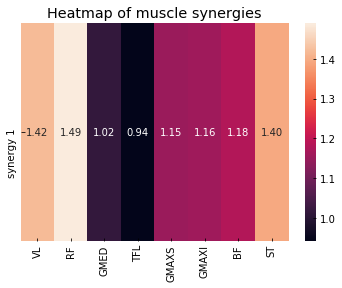

In [21]:
synergy_heatmap(components[1], emg_df.columns)
plt.show()

In [22]:
cols_mean = np.mean(processed_df, axis=0)
cols_mean

VL       0.480469
RF       0.507537
GMED     0.332063
TFL      0.323898
GMAXS    0.380732
GMAXI    0.380571
BF       0.418514
ST       0.479679
dtype: float64

In [23]:
scaled_mean = cols_mean * 1.42 / 0.48
scaled_mean = scaled_mean.to_numpy().reshape(1, -1)
scaled_mean

array([[1.42138757, 1.5014649 , 0.98235198, 0.95819892, 1.1263318 ,
        1.12585588, 1.23810366, 1.41905068]])

In [24]:
def nnmf(matrix_df, num_components, *, max_iter=100_000, tol=1e-6):
    """Factor matrix into non-negative factors."""
    model = NMF(max_iter=100000, tol=1e-6, n_components=num_components)
    transformed_emg_signal = model.fit_transform(matrix_df)
    return transformed_emg_signal, model.components_, model.n_iter_

transf_signal, comps, _ = nnmf(processed_df, 1)
comps

NameError: name 'NMF' is not defined

In [ ]:
transf_signal.shape

In [ ]:
transf_signal[:10, ...]

In [ ]:
error = (transf_signal @ comps - processed_df)
np.abs(error).mean()

In [ ]:
np.abs(processed_df).mean()

In [ ]:
reconstr_with_mean = transf_signal @ scaled_mean - processed_df
np.abs(reconstr_with_mean).mean()

In [ ]:
transf_signal.shape, scaled_mean.shape